In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from keras.metrics import MeanIoU

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt


In [ ]:
# Merged two gray scale images into one image of two channel so that we can input two images as input while training and predction
def merge_data(input1, input2):
  merged_data = []
  for in1, in2 in zip(input1, input2):
    merged_data.append([in1, in2])
  return merged_data


In [ ]:
#Load data path
def load_data():
    my_output = []

    input1 = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/input/*")))
    input2 = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/Masks/*")))
    output = sorted(glob(os.path.join("/content/drive/MyDrive/Dataset/output/*")))


    input1_train,  input1_test = train_test_split(input1, test_size=0.2, shuffle=False)
    input2_train,  input2_test = train_test_split(input2, test_size=0.2, shuffle=False)
    input_train =  merge_data(input1_train, input2_train)
    input_test = merge_data(input1_test, input2_test)

    train_output, test_output = train_test_split(output, test_size=0.2, shuffle=False)
    return (input_train, train_output), (input_test, test_output)

In [ ]:
# pre process
def read_image(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (128, 128))
  x = x/255.0
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=-1)
  return x

In [ ]:
# Read path
def read_input(paths):
  images = []
  for path in paths:
    images.append(read_image(path.decode()))
  new_image =  np.concatenate((images[0], images[1]), axis=-1)
  return new_image

In [ ]:
def read_output(path):
  return read_image(path.decode())

In [ ]:
def preprocess(input_path, output_path):
    def f(input_path, output_path):
        input_path = input_path
        output_path = output_path
        x = read_input(input_path)
        y = read_output(output_path)
        return x, y
    input, output = tf.numpy_function(f, [input_path, output_path], [tf.float32, tf.float32])
    input.set_shape([128, 128, 2])
    output.set_shape([128, 128, 1])
    return input, output

In [ ]:
# Convert to tendor slices
def tf_dataset(input, output, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((input, output))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
kernel_initializer =  'he_uniform'
inputs = Input((128, 128, 2))
s = inputs

#### Down Sample ####

### Block 1 ###
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
c1 = Dropout(0.1)(c1) # To prevent from overfitting.
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
p1 = MaxPooling2D((2, 2), padding='same')(c1)
# 128/2 = 64

### Block 2 ###    
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2) 
p2 = MaxPooling2D((2, 2), padding='same')(c2)
# 64/2 = 32

### Block 3 ###     
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3) 
p3 = MaxPooling2D((2, 2) , padding='same')(c3)
# 32/2  = 16     

### Block 4 ###     
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4) 
p4 = MaxPooling2D((2, 2), padding='same')(c4)
# 16/2 = 8

# Bridge block     
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4) 
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5) 



#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5) # 16 x 16
u6 = concatenate([u6, c4]) # Skipp connection
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6) # 32 x 32
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7) # 64 x 64
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8) # 128 x 128
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr = 1e-3), loss=tf.keras.losses.MeanAbsoluteError(),  metrics=['MSE','MAE', 'RootMeanSquaredError'])
model.summary()
     

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  304         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv2d_17 (Conv2D)             (None, 128, 128, 16  2320        ['dropout_8[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 1)  17          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 1,940,961
Trainable params: 1,940,961
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
batch_size = 8
epochs = 25
(train_x, train_y), (valid_x, valid_y) = load_data()
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
# Model compile
history = model.fit(train_dataset, validation_data=valid_dataset, epochs = epochs, batch_size = batch_size)

Epoch 1/25
80/80 [==============================] - 27s 284ms/step - loss: 0.0396 - MSE: 0.0056 - MAE: 0.0396 - root_mean_squared_error: 0.0751 - val_loss: 0.0318 - val_MSE: 0.0022 - val_MAE: 0.0318 - val_root_mean_squared_error: 0.0466
Epoch 2/25
80/80 [==============================] - 23s 293ms/step - loss: 0.0131 - MSE: 7.3071e-04 - MAE: 0.0131 - root_mean_squared_error: 0.0270 - val_loss: 0.0203 - val_MSE: 7.2208e-04 - val_MAE: 0.0203 - val_root_mean_squared_error: 0.0269
Epoch 3/25
80/80 [==============================] - 23s 288ms/step - loss: 0.0096 - MSE: 2.9224e-04 - MAE: 0.0096 - root_mean_squared_error: 0.0171 - val_loss: 0.0168 - val_MSE: 4.4747e-04 - val_MAE: 0.0168 - val_root_mean_squared_error: 0.0212
Epoch 4/25
80/80 [==============================] - 23s 290ms/step - loss: 0.0078 - MSE: 1.6924e-04 - MAE: 0.0078 - root_mean_squared_error: 0.0130 - val_loss: 0.0134 - val_MSE: 2.6422e-04 - val_MAE: 0.0134 - val_root_mean_squared_error: 0.0163
Epoch 5/25
80/80 [==========

In [ ]:
def load_test_data():
    input1 = sorted(glob(os.path.join("/content/drive/MyDrive/Test_data/input/*")))
    input2 = sorted(glob(os.path.join("/content/drive/MyDrive/Test_data/Masks/*")))
    output = sorted(glob(os.path.join("/content/drive/MyDrive/Test_data/output/*")))
    test_image =  merge_data(input1, input2)
    return test_image, output

In [ ]:
test_x, test_y = load_test_data()
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [ ]:
score = model.evaluate(test_dataset, verbose = 0) 

In [ ]:
dict(zip(model.metrics_names, score))

{'loss': 0.001696826540865004,
 'MSE': 1.650616104598157e-05,
 'MAE': 0.001696826540865004,
 'root_mean_squared_error': 0.0040627773851156235}

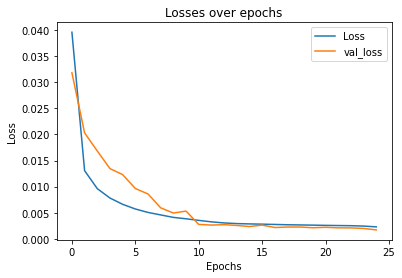

In [ ]:
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Losses over epochs")
# plt.ylim([0, 0.5])
plt.legend()
plt.show()

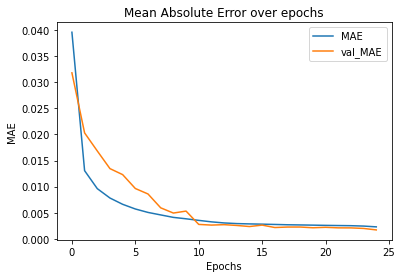

In [ ]:
plt.plot(history.history['MAE'], label="MAE")
plt.plot(history.history['val_MAE'], label="val_MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Mean Absolute Error over epochs")
# plt.ylim([0, 0.5])
plt.legend()
plt.show()

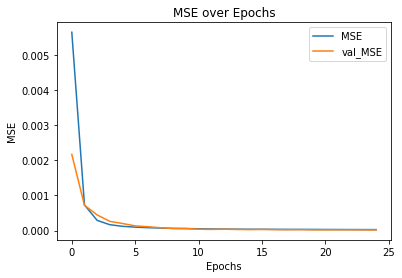

In [ ]:
plt.plot(history.history['MSE'], label="MSE")
plt.plot(history.history['val_MSE'], label="val_MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE over Epochs")
# plt.ylim([0, 0.5])
plt.legend()
plt.show()

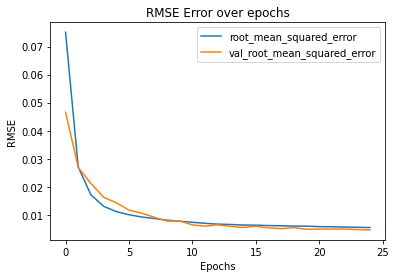

In [ ]:
plt.plot(history.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(history.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("RMSE Error over epochs")
# plt.ylim([0, 0.5])
plt.legend()
plt.show()

In [ ]:
inp = read_image('/content/drive/MyDrive/Final_test_data_external/input/20.png')
mask =  read_image('/content/drive/MyDrive/Final_test_data_external/Masks/20.png')
test_data =  np.concatenate((inp, mask), axis=-1)
test_data = np.expand_dims(test_data, axis=0)

In [ ]:
result  = model.predict(test_data)[0]

In [ ]:
exp_img_path = '/content/drive/MyDrive/Final_test_data_external/output/20.png'
expeted_result =cv2.imread(exp_img_path, cv2.IMREAD_GRAYSCALE)

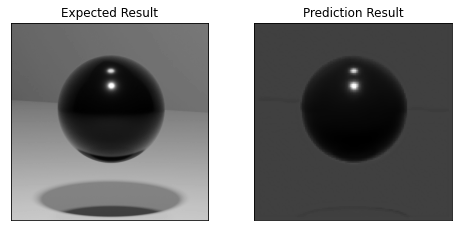

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title('Expected Result')
plt.imshow(expeted_result, cmap='gray'), plt.xticks([]), plt.yticks([])

plt.subplot(222)
plt.title('Prediction Result')
result = np.squeeze(result)
plt.imshow(result, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
def load_external_test_data():
    input1 = sorted(glob(os.path.join("/content/drive/MyDrive/Final_test_data_external/input/*")))
    input2 = sorted(glob(os.path.join("/content/drive/MyDrive/Final_test_data_external/Masks/*")))
    output = sorted(glob(os.path.join("/content/drive/MyDrive/Final_test_data_external/output/*")))
    test_image =  merge_data(input1, input2)
    return test_image, output

In [ ]:
test_e_x, test_e_y = load_external_test_data()
external_test_dataset = tf_dataset(test_e_x, test_e_y, batch=batch_size)

In [ ]:
score_ex = model.evaluate(external_test_dataset, verbose = 0)

In [ ]:
dict(zip(model.metrics_names, score_ex))

{'loss': 0.2670535147190094,
 'MSE': 0.09768453985452652,
 'MAE': 0.2670535147190094,
 'root_mean_squared_error': 0.3125452399253845}